In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.0f}'.format # to print without 1.234e+05

In [ ]:
years = 20
discount_rate = 0.06 # 6% 
energy_cost_per_kwh = 0.9  # kr/KWh

data = {
    "Alternative": ["A1","A2","A3"], 
    "Acquisition Cost (kr)": [500000.0, 1000000.0, 2000000.0], 
    "Annual Energy Consumption (MWh)": [160.0, 150.0, 125.0], 
    "Failure Rate (per year)": [10.0, 5.0, 3.0],
    "MTTR (hr)": [3.0, 3.0, 3.0],
    "Maintenance Cost (kr/hr)": [1000.0, 1500.0, 2000.0],
    "Downtime Cost (kr/hr)": [15000.0, 15000.0, 15000.0],
    "End of Life Cost (kr)": [50000.0, 30000.0, 25000.0]
}

df = pd.DataFrame(data)
df.T

,0,1,2
Alternative,A1,A2,A3
Acquisition Cost (kr),"500,000","1,000,000","2,000,000"
Annual Energy Consumption (MWh),160,150,125
Failure Rate (per year),10,5,3
MTTR (hr),3,3,3
Maintenance Cost (kr/hr),"1,000","1,500","2,000"
Downtime Cost (kr/hr),"15,000","15,000","15,000"
End of Life Cost (kr),"50,000","30,000","25,000"


In [4]:
def annuity(annual_cost, rate, n): # livränta
    return annual_cost * (1 - (1 + rate) ** -n) / rate

In [ ]:

def LCC(df):
    df["Annual Energy Cost (kr)"] = df["Annual Energy Consumption (MWh)"] * 1000 * energy_cost_per_kwh 
    
    df["Annual Unavailability (hr)"] = df["Failure Rate (per year)"] * df["MTTR (hr)"]
    

    df["Annual Maintenance Cost (kr)"] = df["Annual Unavailability (hr)"] * df["Maintenance Cost (kr/hr)"]

    df["Annual Downtime Cost (kr)"] = df["Annual Unavailability (hr)"] * df["Downtime Cost (kr/hr)"]

    df["Total Annual Cost (kr)"] = (
        df["Annual Energy Cost (kr)"] + 
        df["Annual Maintenance Cost (kr)"] + 
        df["Annual Downtime Cost (kr)"]
    )


    df["NPV of Annual Costs (kr)"] = annuity(df["Total Annual Cost (kr)"], discount_rate, years)
    
    
    df["LCC"] = (
        df["Acquisition Cost (kr)"] +
        df["NPV of Annual Costs (kr)"] + 
        df["End of Life Cost (kr)"]
    )
    return df 


def lowest_LCC_alt(df):
    df = LCC(df)
    return df[df["LCC"] == df["LCC"].min()]["Alternative"].values[0] # 

In [6]:
df = pd.DataFrame(data)
lowest_lcc = lowest_LCC_alt(df)
print(df[["Alternative", "LCC"]])
print("="*50)
print(f"Most economical alternative (lowest LCC): {lowest_lcc}")

  Alternative       LCC
0          A1 7,707,231
1          A2 5,417,245
2          A3 5,070,264
Most economical alternative (lowest LCC): A3


In [22]:

df.T

,0,1,2
Alternative,A1,A2,A3
Acquisition Cost (kr),"500,000","1,000,000","2,000,000"
Annual Energy Consumption (MWh),160,150,125
Failure Rate (per year),0,5,3
MTTR (hr),3,3,3
Maintenance Cost (kr/hr),"1,000","1,500","2,000"
Downtime Cost (kr/hr),"15,000","15,000","15,000"
End of Life Cost (kr),"50,000","30,000","25,000"
Annual Energy Cost (kr),"144,000","135,000","112,500"
Annual Unavailability (hr),0,15,9


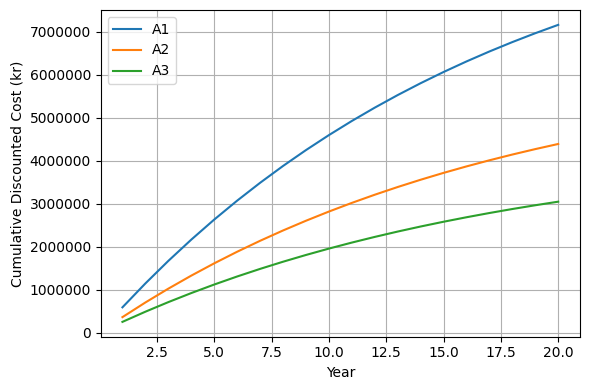

In [8]:

cumulative_costs = {}
for i, row in df.iterrows():
    alt = row["Alternative"]
    sum = 0
    cumulative_costs[alt] = []
    for year in range(1,years+1):
        sum += row["Total Annual Cost (kr)"] / ((1 + discount_rate) ** year)
        cumulative_costs[alt].append(sum)

cumulative_df = pd.DataFrame(cumulative_costs)
cumulative_df["Year"] = range(1, years + 1)

plt.figure(figsize=(6, 4))
for alt in df["Alternative"]:
    plt.plot(cumulative_df["Year"], cumulative_df[alt], label=alt)
plt.xlabel("Year")
plt.ylabel("Cumulative Discounted Cost (kr)")
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("imgs/cumsum_discount.png", dpi=300)
plt.show()

<Figure size 600x400 with 0 Axes>

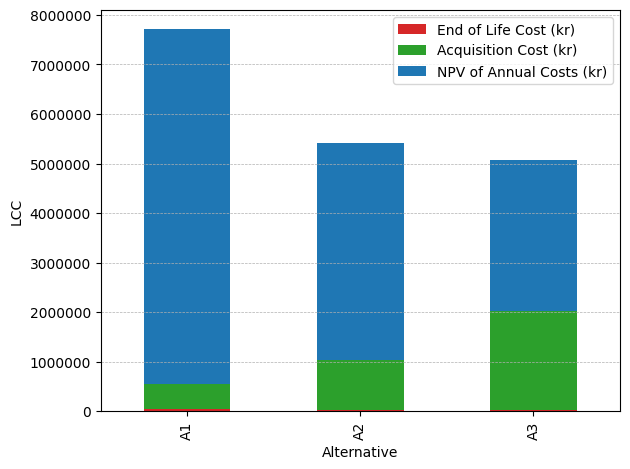

In [10]:
bar_data = pd.DataFrame({
    "Alternative": df["Alternative"],
    "End of Life Cost (kr)": df["End of Life Cost (kr)"],
    "Acquisition Cost (kr)": df["Acquisition Cost (kr)"],
    "NPV of Annual Costs (kr)": df["NPV of Annual Costs (kr)"]
}).set_index("Alternative")

plt.figure(figsize=(6, 4))
bar_data.plot(kind="bar", stacked=True, color=["#d62728", "#2ca02c", "#1f77b4"])
plt.ylabel("LCC")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("imgs/lcc_stacked.png", dpi=300)
plt.show()

In [11]:
# c) Vary at least four calculation parameters (-20%, -10%, 10% 20%)
# in the analysis and discuss the results. Which of the parameters 
# is/are sensitive enough to alter the initial result with the default
# setting of the parameters?

parameters = [
    "Acquisition Cost (kr)",
    "Annual Energy Consumption (MWh)",
    "Failure Rate (per year)",
    "MTTR (hr)",
    "Maintenance Cost (kr/hr)",
    "Downtime Cost (kr/hr)",
    "End of Life Cost (kr)"
]
#[0.8, 0.9, 1.1, 1.2] # -20%, -10%, +10%, +20%
change_range = np.arange(0.4, 1.6, 0.1)
alt = [0]
results = {}
for param in parameters:
    results[param] = []
    for change in change_range:
        df = pd.DataFrame(data) # reset dataframe to og data
        for a in alt:
            df.loc[a, param] *= change
        lowest_lcc = lowest_LCC_alt(df.copy())
        results[param].append(lowest_lcc)

def percent_labels(change_range): # factor -> percent increas/decrease
    return [f"{'+' if f > 1 else '-' if f < 1 else ''}{abs(round((f - 1) * 100))}%" for f in change_range]

result_df = pd.DataFrame(results)
result_df.index = percent_labels(change_range)
result_df.T

,-60%,-50%,-40%,-30%,-20%,-10%,-0%,+10%,+20%,+30%,+40%,+50%,+60%
Acquisition Cost (kr),A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3
Annual Energy Consumption (MWh),A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3
Failure Rate (per year),A1,A1,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3
MTTR (hr),A1,A1,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3
Maintenance Cost (kr/hr),A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3
Downtime Cost (kr/hr),A1,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3
End of Life Cost (kr),A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3,A3


In [ ]:
# trying to make A1 best:
from itertools import product

df = pd.DataFrame(data)

failure_rate_range = np.arange(0.3, 1.0, 0.01) 
mttr_range = [1]#np.arange(0.5, 1.0, 0.05)          
maintenance_cost_range = [1]#np.arange(0.5, 1.0, 0.1)  

parameters = [
    "Failure Rate (per year)",
    "MTTR (hr)",
    "Maintenance Cost (kr/hr)"
]

test_combinations = list(product(failure_rate_range, mttr_range, maintenance_cost_range))
results = []

for combination in test_combinations:
    df = pd.DataFrame(data).copy()
    df = df.astype({param: float for param in parameters})

    # Apply changes to A1 only
    df_copy = df.copy()
    for i, param in enumerate(parameters):
        df_copy.loc[0, param] *= combination[i]

    lowest_lcc = lowest_LCC_alt(df_copy)
    results.append({
        # for some reason when i tried to make this dict into a df, it forced everythign to an int so everything was just 1...
        "Failure Rate Factor": combination[0]*100,
        "MTTR Factor": combination[1]*100,
        "Maintenance Cost Factor": combination[2]*100,
        "Lowest LCC": lowest_lcc
    })

if not results:
    print("uh oh, no results!")
else:
    res = pd.DataFrame(results)

    res["Failure Rate Factor"] = res["Failure Rate Factor"].astype(float)
    res["MTTR Factor"] = res["MTTR Factor"].astype(float)
    res["Maintenance Cost Factor"] = res["Maintenance Cost Factor"].astype(float)


    res["Deviation"] = (
        abs(res["Failure Rate Factor"] - 100) +
        abs(res["MTTR Factor"] - 100) +
        abs(res["Maintenance Cost Factor"] - 100)
    )

    # only care when a1 iis best
    a1_res = res[res["Lowest LCC"] == "A1"]
a1_res.sort_values("Deviation").head(10)


,Failure Rate Factor,MTTR Factor,Maintenance Cost Factor,Lowest LCC,Deviation
22,52,100,100,A1,48
21,51,100,100,A1,49
20,50,100,100,A1,50
19,49,100,100,A1,51
18,48,100,100,A1,52
17,47,100,100,A1,53
16,46,100,100,A1,54
15,45,100,100,A1,55
14,44,100,100,A1,56
13,43,100,100,A1,57


In [13]:
# d) When is the payback period of alternatives 2 and 3 
# (these alternatives have higher initial costs) 
# compared to alternative 1?
df = pd.DataFrame(data)
LCC(df)

alt1 = df[df["Alternative"] == "A1"].iloc[0]
alt2 = df[df["Alternative"] == "A2"].iloc[0]
alt3 = df[df["Alternative"] == "A3"].iloc[0]

initial_cost_2 = alt2["Acquisition Cost (kr)"]
initial_cost_3 = alt3["Acquisition Cost (kr)"]

annual_cost_1 = alt1["Total Annual Cost (kr)"]
annual_cost_2 = alt2["Total Annual Cost (kr)"]
annual_cost_3 = alt3["Total Annual Cost (kr)"]

years_range = np.arange(0, 21)
cumulative_savings_2 = (annual_cost_1 - annual_cost_2) * years_range 
cumulative_savings_3 = (annual_cost_1 - annual_cost_3) * years_range

In [14]:
# finds payback year
def payback_period(cumulative_savings, initial_cost):
    for i in range(1, len(cumulative_savings)):
        if cumulative_savings[i] >= initial_cost:
            x0, y0 = i - 1, cumulative_savings[i - 1]
            x1, y1 = i, cumulative_savings[i]
            return x0 + (initial_cost - y0) / (y1 - y0)
    return None

payback_2 = payback_period(cumulative_savings_2, initial_cost_2)
payback_3 = payback_period(cumulative_savings_3, initial_cost_3)


# finds y value for said payback year
def interpolate_y(cumulative_savings, payback_year):
    y0 = cumulative_savings[i]
    y1 = cumulative_savings[i + 1]
    return y0 + (payback_year - i) * (y1 - y0)

dot_y_2 = interpolate_y(cumulative_savings_2, payback_2)
dot_y_3 = interpolate_y(cumulative_savings_3, payback_3)



A2: 4.14 A3: 5.58


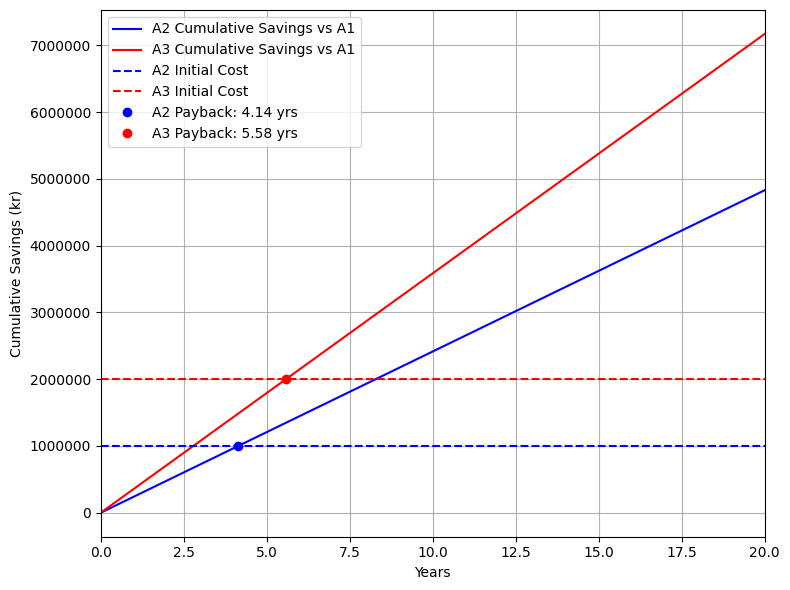

In [20]:
plt.figure(figsize=(8,6))
plt.plot(years_range, cumulative_savings_2, label="A2 Cumulative Savings vs A1",color="blue")
plt.plot(years_range, cumulative_savings_3, label="A3 Cumulative Savings vs A1", color="red")
plt.axhline(y=initial_cost_2, color='blue', linestyle='--', label="A2 Initial Cost")
plt.axhline(y=initial_cost_3, color='red', linestyle='--', label="A3 Initial Cost")

plt.plot(payback_2, dot_y_2, 'o', color='blue', label=f"A2 Payback: {payback_2:.2f} yrs")
plt.plot(payback_3, dot_y_3, 'o', color='red', label=f"A3 Payback: {payback_3:.2f} yrs")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Years")
plt.ylabel("Cumulative Savings (kr)")
plt.legend()
plt.grid(True)
plt.xlim([0, 20])
plt.tight_layout()
plt.savefig("imgs/payback_periods.png", dpi=300)
print(f"A2: {payback_2:.2f} A3: {payback_3:.2f}")
plt.show()

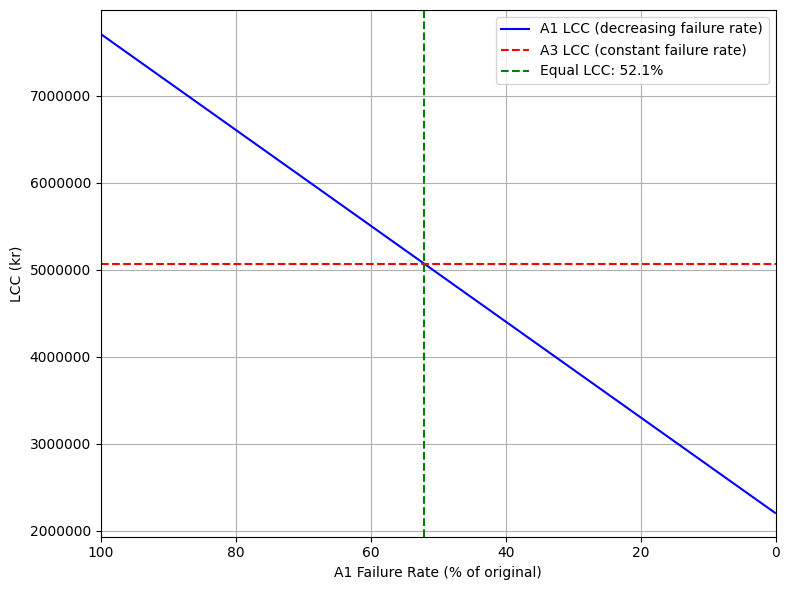

In [19]:
# e) blablabla find lowest failure rate s.t A1 has lowest LCC

df = LCC(pd.DataFrame(data))
failure_rate_range = np.arange(1, 0, -0.001)

a3_lcc = df[df["Alternative"] == "A3"]["LCC"].values[0]
a1_lccs = []

df=pd.DataFrame(data)
for failure_rate_factor in failure_rate_range:
    df=pd.DataFrame(data).copy()
    df.loc[0, "Failure Rate (per year)"] *= failure_rate_factor
    df = LCC(df)
    a1_lccs.append(df[df["Alternative"] == "A1"]["LCC"].values[0])


for i, lcc in enumerate(a1_lccs):
    if lcc < a3_lcc:
        crossing_rate_lcc = failure_rate_range[i]
        break

    
plt.figure(figsize=(8, 6))
plt.plot(failure_rate_range * 100, a1_lccs, label="A1 LCC (decreasing failure rate)", color="blue")
plt.axhline(y=a3_lcc, color="red", linestyle="--", label="A3 LCC (constant failure rate)")
plt.axvline(x=crossing_rate_lcc * 100, color="green", linestyle="--", label=f"Equal LCC: {crossing_rate_lcc*100:.1f}%")
plt.xlabel("A1 Failure Rate (% of original)")
plt.ylabel("LCC (kr)")
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.grid(True)
plt.xlim([100, 0])
plt.tight_layout()
plt.savefig("imgs/a1_vs_a3_lcc",dpi=300)
plt.show()
    